In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# 1. LOAD AND PREPARE THE DATA

# Load the dataset
try:
    # Use the filename you uploaded
    df = pd.read_csv("Life_Expectancy_Data (1).csv")
except FileNotFoundError:
    print("---! ERROR !---")
    print("Make sure you have uploaded 'Life_Expectancy_Data (1).csv' to Colab!")
    print("Click the 'Files' icon on the left and 'Upload'.")
    raise

print(f"Original data shape: {df.shape}")

# Data Cleaning

# 1. Fix messy column names (e.g., "Life expectancy " -> "Life expectancy")
df.columns = df.columns.str.strip()

# 2. Drop rows where our target ('Life expectancy') is missing
df = df.dropna(subset=['Life expectancy'])

# 3. Handle categorical columns: 'Country' and 'Status'
# 'Country' has too many unique values for this model, so we'll drop it.
# 'Status' is perfect. We'll convert it to numbers (0s and 1s).
df_processed = pd.get_dummies(df, columns=['Status'], drop_first=True)
df_processed = df_processed.drop('Country', axis=1)

# 4. Fill remaining missing values (like in 'GDP', 'Alcohol', etc.)
# We will use the median of each column for a simple, robust fill.
numeric_cols = df_processed.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if col != 'Life expectancy': # Don't fill our target
        median_val = df_processed[col].median()
        df_processed[col] = df_processed[col].fillna(median_val)

print(f"Cleaned data shape: {df_processed.shape}")
print("\n--- Data is clean and ready! ---")



# 2. DEFINE X (FEATURES) AND y (TARGET)

y = df_processed['Life expectancy']
X = df_processed.drop('Life expectancy', axis=1)


# 3. SPLIT DATA AND SCALE FEATURES

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
# SVR, PCA, and Linear Regression NEED data to be scaled.
# It doesn't hurt Random Forests, so it's safe to do for all.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")


# 4. TRAIN AND EVALUATE ALL MODELS

# Create the PCA + SVR Pipeline
# This pipeline will first run PCA to keep 95% of the variance,
# and then run SVR on those new components.
pca_svm_pipeline = Pipeline([
    ('pca', PCA(n_components=0.95)),
    ('svr', SVR())
])

# --- Define all the models we want to try ---
models = {
    "Linear Regression": LinearRegression(),
    "SVR (Support Vector)": SVR(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "PCA + SVR": pca_svm_pipeline
}

# A dictionary to store the results
results = {}

print("\n--- Training and Evaluating Models ---")

# Loop through each model, train it, and get its score
for name, model in models.items():

    # Train the model
    # Note: We are training all models on the SCALED data
    model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Calculate R-squared and Mean Absolute Error
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Store the results
    results[name] = {"R² Score": r2, "Mean Absolute Error": mae}
    print(f"✅ {name} - Trained.")


# 5. SHOW THE COMPARISON
print("\n--- Model Comparison Results ---")

# Convert results to a DataFrame for pretty printing
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="R² Score", ascending=False)

print(results_df)

print("\n--- Interpretation ---")
print("R² Score: Higher is better (1.0 is perfect). Measures how much of the variation the model can explain.")
print("Mean Absolute Error: Lower is better. This is the average error in years (e.g., 2.5 means the model is off by 2.5 years on average).")

Original data shape: (1649, 22)
Cleaned data shape: (1649, 21)

--- Data is clean and ready! ---

Training data shape: (1319, 20)
Testing data shape: (330, 20)

--- Training and Evaluating Models ---
✅ Linear Regression - Trained.
✅ SVR (Support Vector) - Trained.
✅ Random Forest - Trained.
✅ PCA + SVR - Trained.

--- Model Comparison Results ---
                      R² Score  Mean Absolute Error
Random Forest         0.948324             1.131752
SVR (Support Vector)  0.858336             2.232494
PCA + SVR             0.853210             2.293878
Linear Regression     0.816749             2.750004

--- Interpretation ---
R² Score: Higher is better (1.0 is perfect). Measures how much of the variation the model can explain.
Mean Absolute Error: Lower is better. This is the average error in years (e.g., 2.5 means the model is off by 2.5 years on average).


/tmp/ipython-input-4021947724.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df_sorted_r2.index, y="R² Score", data=results_df_sorted_r2, ax=ax1, palette="Greens_r")
/tmp/ipython-input-4021947724.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df_sorted_mae.index, y="Mean Absolute Error", data=results_df_sorted_mae, ax=ax2, palette="Reds_r")


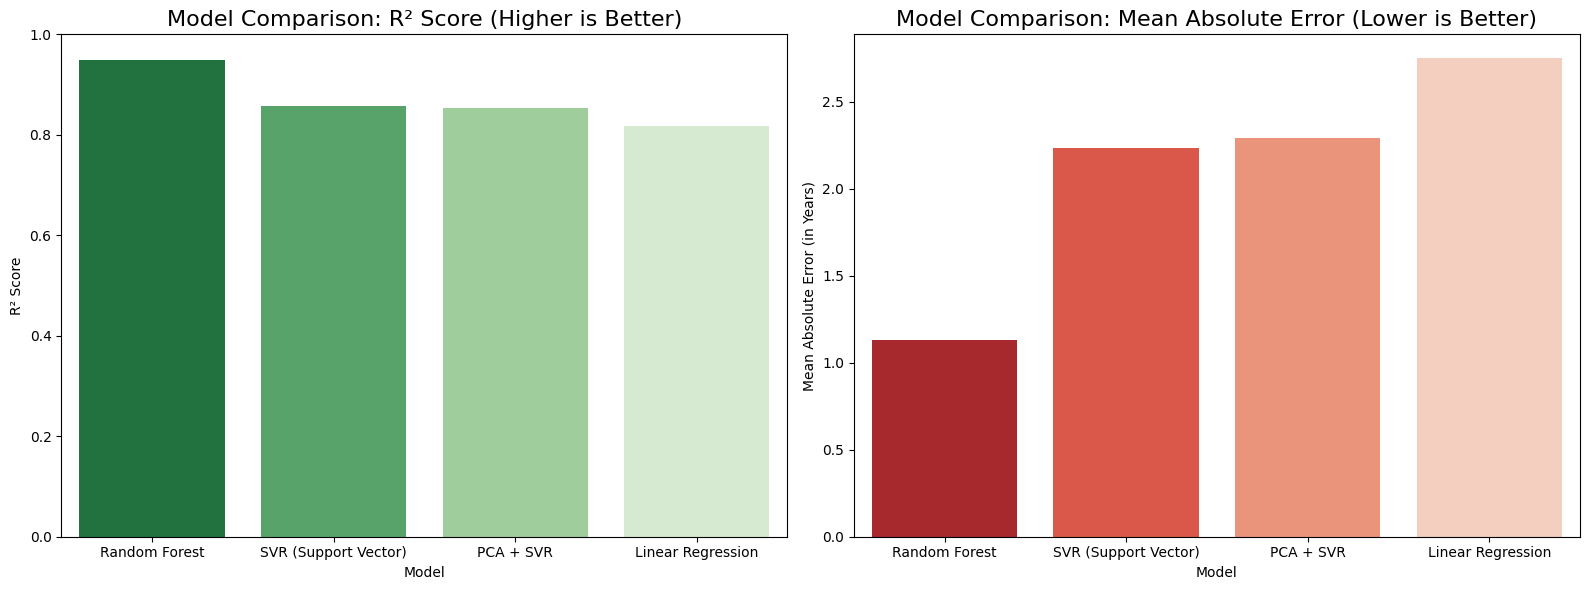

In [ ]:
# 1. PLOT 1: MODEL PERFORMANCE COMPARISON
# We create two bar plots side-by-side:
# 1. R² Score (Higher is better)
# 2. Mean Absolute Error (Lower is better)

# Sort the results for better visualization
results_df_sorted_r2 = results_df.sort_values(by="R² Score", ascending=False)
results_df_sorted_mae = results_df.sort_values(by="Mean Absolute Error", ascending=True)

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for R² Score
sns.barplot(x=results_df_sorted_r2.index, y="R² Score", data=results_df_sorted_r2, ax=ax1, palette="Greens_r")
ax1.set_title('Model Comparison: R² Score (Higher is Better)', fontsize=16)
ax1.set_xlabel('Model')
ax1.set_ylabel('R² Score')
ax1.set_ylim(0, 1.0) # Set Y-axis from 0 to 1 for R²

# Plot for Mean Absolute Error
sns.barplot(x=results_df_sorted_mae.index, y="Mean Absolute Error", data=results_df_sorted_mae, ax=ax2, palette="Reds_r")
ax2.set_title('Model Comparison: Mean Absolute Error (Lower is Better)', fontsize=16)
ax2.set_xlabel('Model')
ax2.set_ylabel('Mean Absolute Error (in Years)')

# Show the plots
plt.tight_layout()
plt.show()

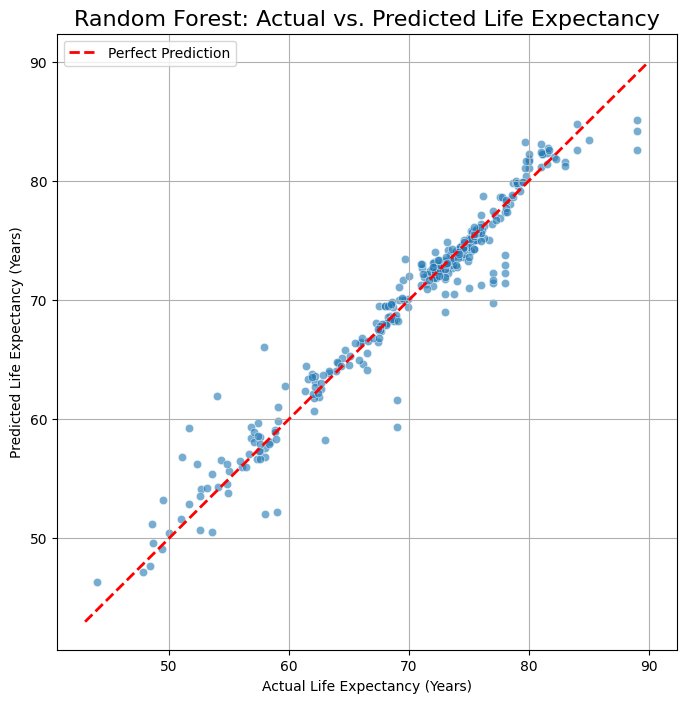

In [ ]:
# 2. PLOT 2: ACTUAL vs. PREDICTED (for the BEST model)
# We'll use your best model: Random Forest

# Get the trained Random Forest model from your 'models' dictionary
best_model = models["Random Forest"]

# Get its predictions on the test set
y_pred_best = best_model.predict(X_test_scaled)

# Create the scatter plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6)

# Add the "perfect prediction" line (a 45-degree dashed red line)
# Find the min and max values to set the line's limits
min_val = min(y_test.min(), y_pred_best.min()) - 1
max_val = max(y_test.max(), y_pred_best.max()) + 1
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Perfect Prediction")

# Set titles and labels
plt.title('Random Forest: Actual vs. Predicted Life Expectancy', fontsize=16)
plt.xlabel('Actual Life Expectancy (Years)')
plt.ylabel('Predicted Life Expectancy (Years)')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-2628389103.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")


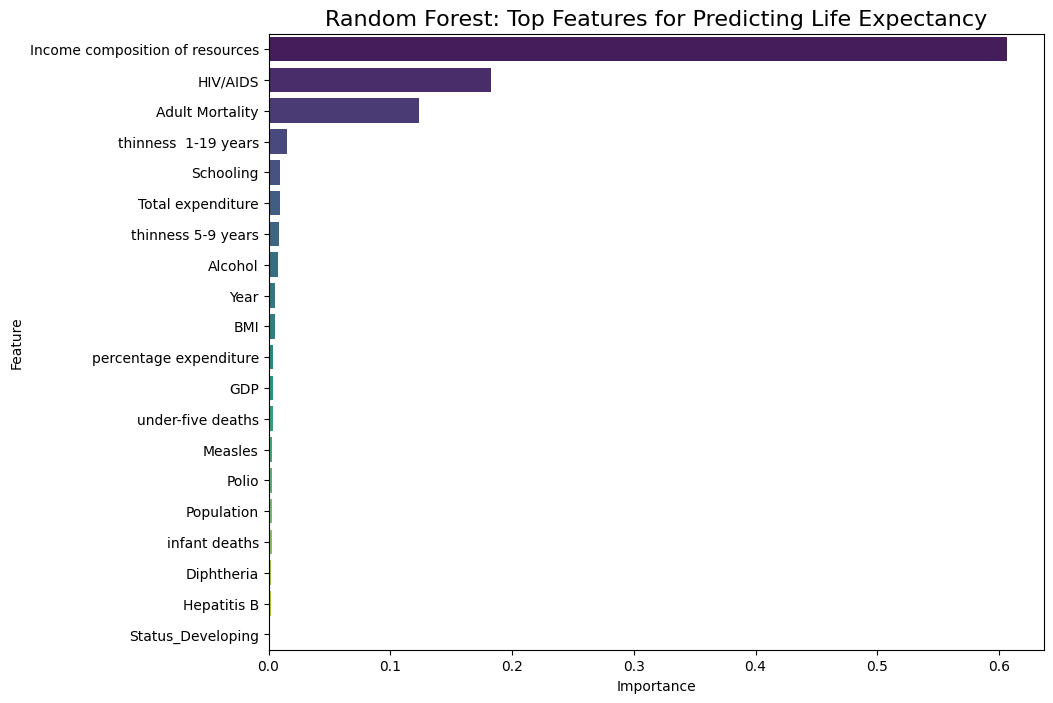


--- Top 5 Most Important Features ---
                            Feature  Importance
17  Income composition of resources    0.606238
12                         HIV/AIDS    0.182591
1                   Adult Mortality    0.123738
15             thinness  1-19 years    0.014879
18                        Schooling    0.009364


In [ ]:
# 3. PLOT 3: FEATURE IMPORTANCE (for the BEST model)
# This shows us WHICH features the Random Forest found most useful.

# Get the feature importances from the trained model
importances = best_model.feature_importances_

# Get the names of the features (from your 'X' DataFrame)
feature_names = X.columns

# Create a DataFrame to hold the feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False) # Sort by importance

# Create the bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")

# Set titles and labels
plt.title('Random Forest: Top Features for Predicting Life Expectancy', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

print("\n--- Top 5 Most Important Features ---")
print(feature_importance_df.head(5))

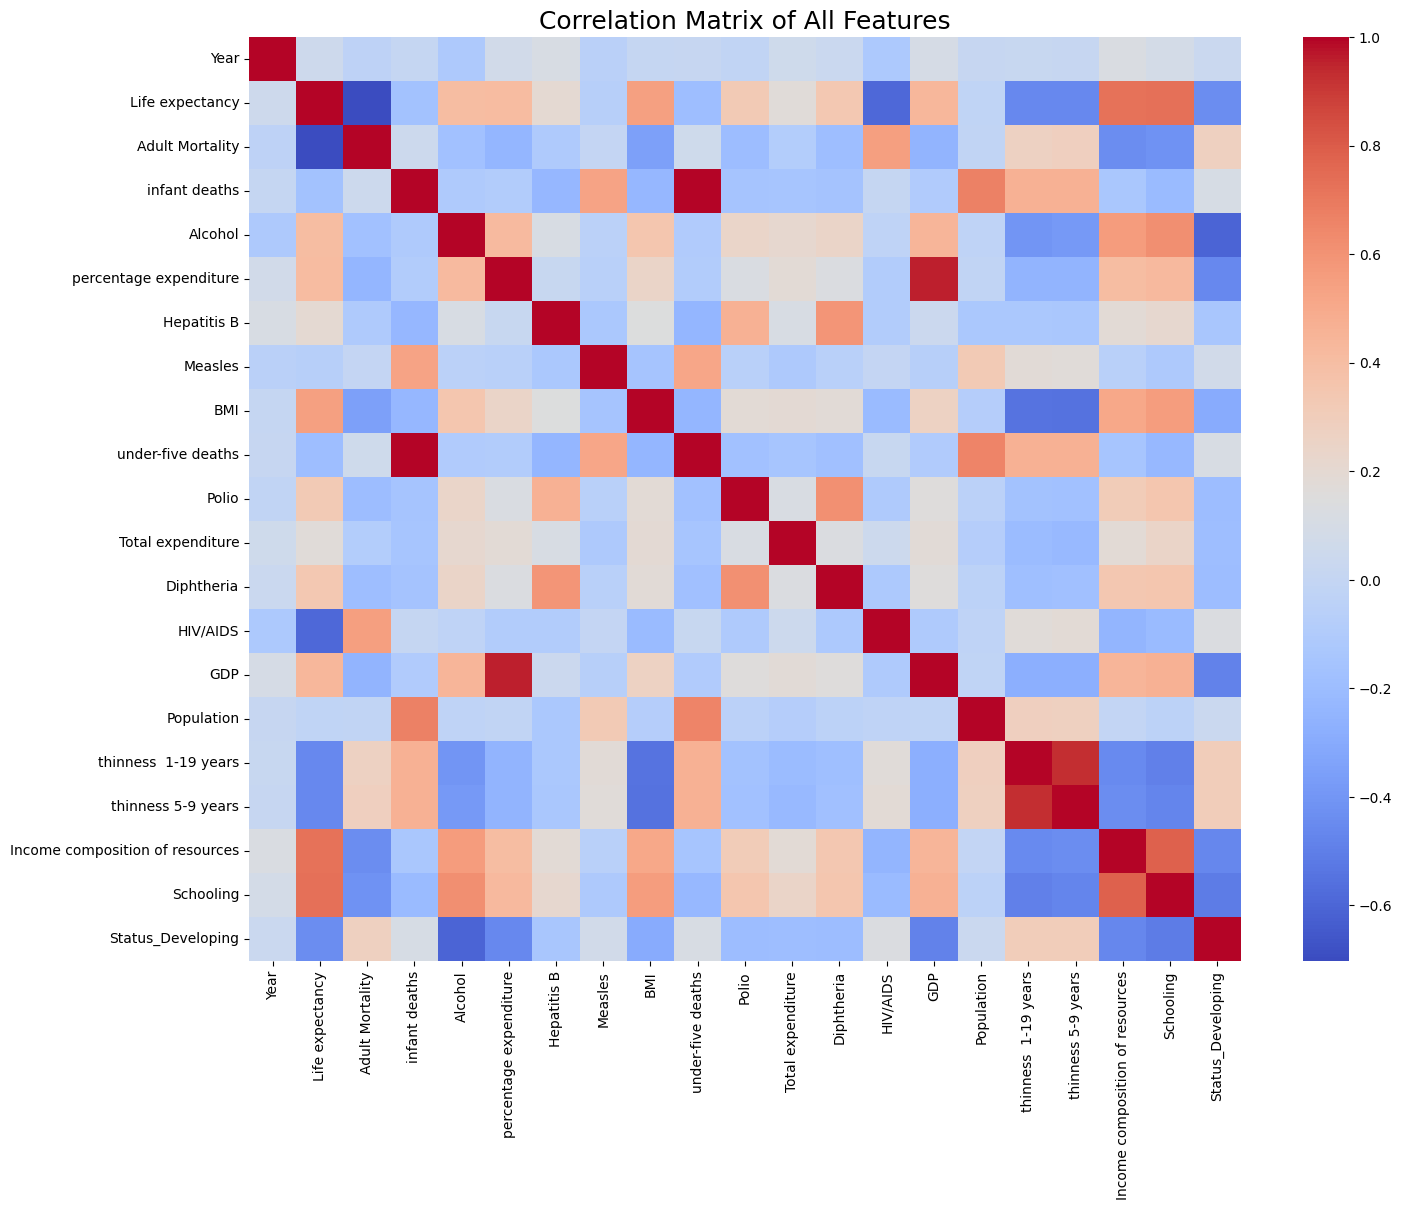

In [ ]:
# 4. PLOT 4: CORRELATION HEATMAP (Data Exploration)
# This shows which features are naturally correlated with each other.

plt.figure(figsize=(16, 12))

# Use your cleaned 'df_processed' DataFrame
corr = df_processed.corr()


# Create the heatmap
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f")

# Set title
plt.title('Correlation Matrix of All Features', fontsize=18)
plt.show()

In [ ]:
import joblib

# 1. Save the trained Random Forest model
joblib.dump(models["Random Forest"], "random_forest_model.joblib")

# 2. Save the fitted scaler
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']